# Fraud Classification Model

# Imports

In [2]:
#pip install -U imbalanced-learn
#!pip install xgboost
#Python 3.11.5

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from xgboost import Booster
from xgboost import DMatrix
from sklearn import metrics
from datetime import datetime

# Reading in Data

In [3]:
# Reading CSV

dataDF = pd.read_csv("Data/creditcard.csv")
dataDF.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Data Distribution

As we can see below, our data is heavily imbalanced. Due to the imbalance we will have to make sure we manage assumptions for any algorithms of choice later when deciding which model to use.

<Axes: title={'center': 'Fraud Class Count'}, xlabel='Class'>

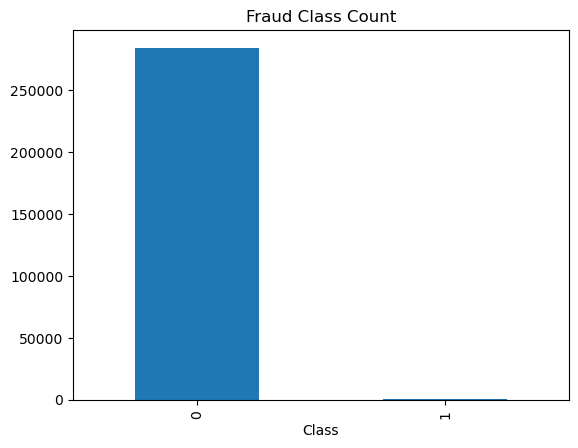

In [4]:
# Creating a series to analyze the target variable.
fraud_counts = dataDF["Class"].value_counts()
fraud_counts.plot(kind="bar", title="Fraud Class Count")

In [5]:
# See actuals for 'not fraud' and 'fraud'
print(f'Fraud Counts:\n{fraud_counts}\n\n')

# Calculate percentages
total_instances = len(dataDF)
fraud_percentage = (fraud_counts / total_instances) * 100

# The below will print out the Class Percentages using the fraud_percetange variable columns, which are "Class 0" and "Class 1".
print(f'Class Percentages:\nClass 0: {fraud_percentage[0]:.2f}%') # Here we are setting the floating-point numbers in the output to a specified decimal place, which is 2.
print(f'Class 1: {fraud_percentage[1]:.2f}%') # Here we are setting the floating-point numbers in the output to a specified decimal place, which is 2.


Fraud Counts:
Class
0    284315
1       492
Name: count, dtype: int64


Class Percentages:
Class 0: 99.83%
Class 1: 0.17%


As we can see from the above, the Class counts for Fraud are heavily outweighed by the Non-Fraud transactions. This is important when considering the assumptions of a model and the ramifications of choosing a model that may be sensitive to imbalanced data.  

# Null Check - 

In [6]:
print(f"Null Count:\n{dataDF.isnull().sum().max()}")


Null Count:
0


# Data Describe Statistics

In [7]:
# This is just to show what it would've looked like
dataDF.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [8]:
# Here we are setting the floating-point numbers in the output to a specified decimal place, which is 2.
# The set_option value is not tied to a specific DataFrame; rather, it affects the display of all floating-point numbers in Pandas DataFrames for the current session.
pd.set_option("display.float_format", lambda x: "%.2f" % x)

dataDF.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


#### Addressing class imbalance, handling outliers, and scaling features might be considerations when preparing the data for machine learning models.

#### Below we can take a look at the 25% percentile compared to the min, which may identify early onset lower-bound outliers. In the same breath, we can do the exact same for the values at the upper 75th percentile to the max for potential upper bound outliers. 

#### It's also good to note the variability in the Amount of a transaction. Some machine learning models, including XGBoost, are sensitive to the scale of features. Features with larger scales might dominate the learning process, leading to biased models. Standardizing or normalizing features by dividing them by their standard deviations may help in mitigating this issue, or one might use a Regularization method to prevent overfitting. 

#### Features with high standard deviations might be more sensitive to outliers. Outliers can disproportionately influence models, leading to suboptimal performance. It's important to address outliers in the data preprocessing step to prevent them from negatively impacting the model.

#### In XGBoost, the algorithm calculates feature importance based on how frequently a feature is used to split the data across all trees in the ensemble. Features with higher standard deviations might have more impact on the model's decisions, but this doesn't necessarily mean they are more important for prediction. It's crucial to interpret feature importance in the context of the specific problem.

#### In summary, while standard deviation itself is not directly used as a parameter in XGBoost, it can influence various aspects of the modeling process, from preprocessing and feature engineering to model interpretation and performance evaluation. Understanding these effects and taking appropriate actions during the data preprocessing and model training stages is crucial for building effective and robust classification models.

In [9]:
dataDF[["Amount", "Time"]].describe() # In this particular code we are only interested in "Amount" and "Time"

,Amount,Time
count,284807.00,284807.00
mean,88.35,94813.86
std,250.12,47488.15
min,0.00,0.00
25%,5.60,54201.50
50%,22.00,84692.00
75%,77.16,139320.50
max,25691.16,172792.00


# Next, we can take a look at some histograms to get a better visual of what the data looks like when plotted.

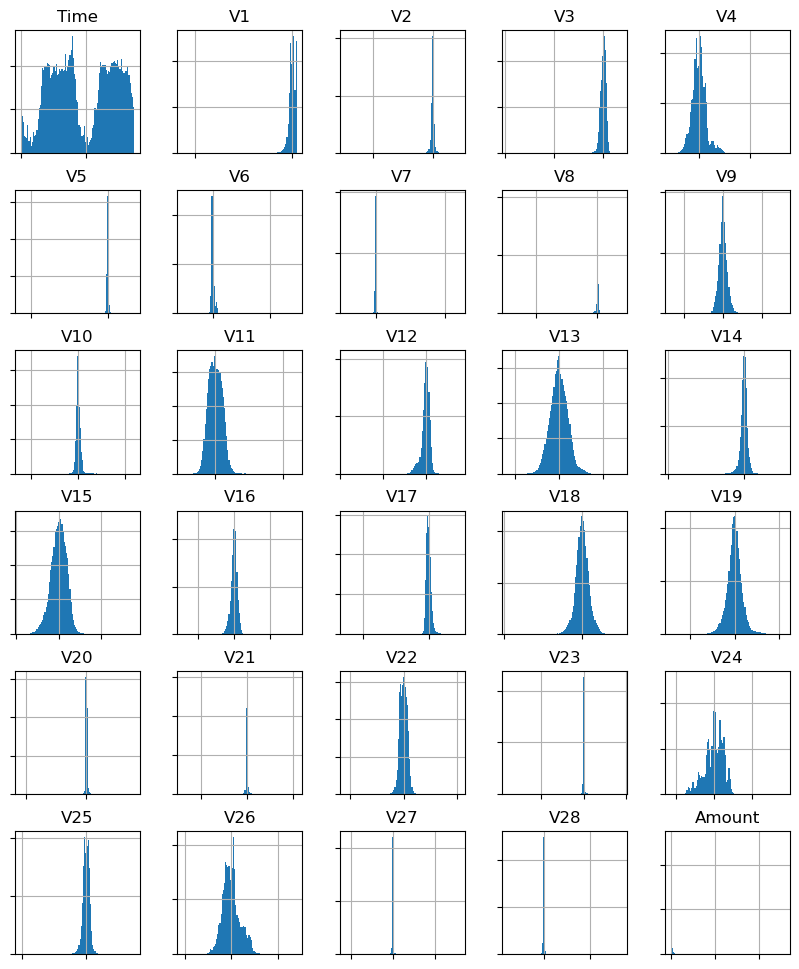

In [10]:
# We will now drop the Target/Dependent variable "Class" and visualize the distribution and characteristics of the independent variables influencing the algorithms predictions.
dropclassDF = dataDF.drop("Class", axis=1).hist(figsize=(10,12),bins=100)
# We hide the axes' labels to make the plot neater and more compact
for axis in dropclassDF.flatten(): # this will remove the x and y labels
    axis.set_xticklabels([])
    axis.set_yticklabels([])

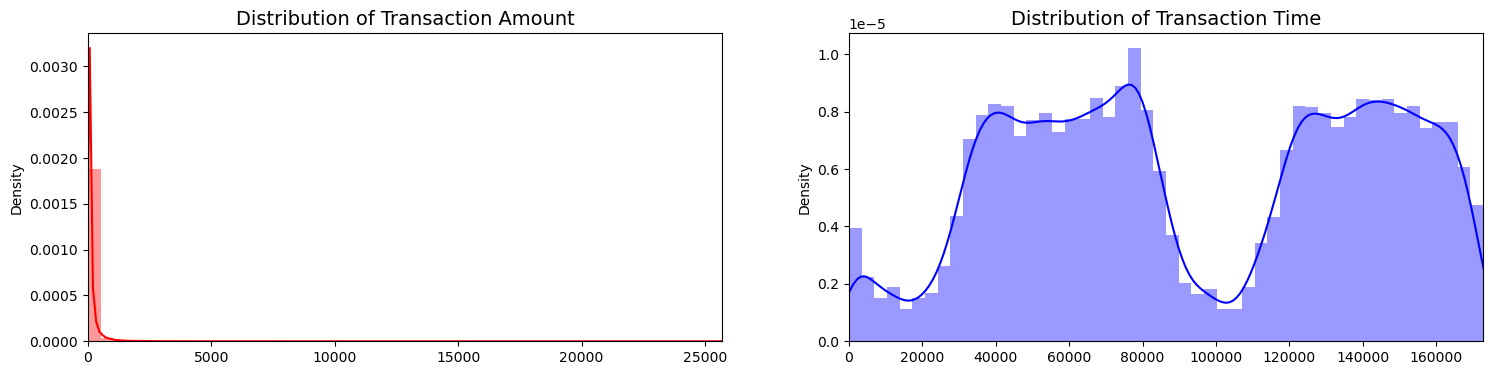

In [11]:
import warnings
from IPython.utils import io
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = dataDF['Amount'].values
time_val = dataDF['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()